# UM analysis

A cleaned up version for me to bug check and then make public with the paper.

## Imports, formatting, plotting config etc

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits
import time
import pandas as pd
import scipy
import sklearn

# My libs
import data
import plots as p
import smhm_fit
import fits
import halo_info
import origin_scatter
from cylinder_length import explore

/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load("sfr_catalog_insitu_exsitu_0.712400_final_extended_wpid_wssfr_wv.npz")
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

11.50023647482564
1124544


## And create true M\*x

In [7]:
data_stellar_cut, data_halo_cut = data.cuts_with_sats(centrals, satellites)

['3.60e+13', '4.42e+11', '9.93e-01', '1.09e-02', '1.95e+00']
['4.36e+12', '7.35e+10', '4.93e-01', '2.27e-01', '2.86e+00']
['3.60e+13', '4.42e+11', '9.93e-01', '1.09e-02', '1.95e+00']
['4.36e+12', '7.35e+10', '4.93e-01', '2.27e-01', '2.86e+00']
['2.20e+13', '3.97e+11', '7.30e-01', '1.53e-01', '1.76e+00']
['4.10e+12', '9.65e+10', '4.33e-01', '2.37e-01', '1.67e+00']
['1.95e+13', '3.58e+11', '7.50e-01', '1.47e-01', '1.66e+00']
['3.07e+12', '6.68e+10', '3.73e-01', '2.31e-01', '1.75e+00']
['1.88e+13', '3.95e+11', '4.78e-01', '2.30e-01', '1.83e+00']
['3.41e+12', '9.04e+10', '3.83e-01', '2.36e-01', '1.38e+00']
['1.52e+13', '3.24e+11', '5.30e-01', '2.12e-01', '1.65e+00']
['2.47e+12', '5.77e+10', '3.11e-01', '2.28e-01', '1.60e+00']
['1.74e+13', '4.13e+11', '7.24e-01', '1.66e-01', '1.17e+00']
['2.34e+12', '6.85e+10', '2.90e-01', '2.28e-01', '1.18e+00']
['1.40e+13', '3.15e+11', '8.20e-01', '1.27e-01', '1.02e+00']
['2.18e+12', '5.21e+10', '2.72e-01', '2.16e-01', '1.65e+00']
['2.92e+13', '6.32e+11',

/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


['4.20e+14', '9.80e+10', '5.27e+00', '4.48e-02', '1.42e+00']


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


['4.20e+14', '9.80e+10', '5.27e+00', '4.48e-02', '1.42e+00']


In [8]:
for key in data_stellar_cut.keys():
    data_stellar_cut[key]["smf"] = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf_cut"] = fits.build_csmf(data_stellar_cut, key, True)

for key in data_halo_cut.keys():
    data_halo_cut[key]["smf"] = fits.build_csmf(data_halo_cut, key)
    data_halo_cut[key]["smf_cut"] = fits.build_csmf(data_halo_cut, key, True)

data_stellar_cut["cen"]["hmf"] = fits.build_chmf(data_stellar_cut, "cen")

In [9]:
for ds in [data_stellar_cut, data_halo_cut]:
    for key in ds.keys():
        for key2 in ds[key].keys():
            if type(ds[key][key2]) is np.ndarray:
                ds[key][key2].setflags(write=False)
            elif type(ds[key][key2]) is tuple:
                for i in range(len(ds[key][key2])):
                    ds[key][key2][i].setflags(write=False)

In [10]:
richness = {
    "richness": data.create_richness_data(centrals, satellites),
}
richness["rmf"] = fits.build_rmf(richness["richness"])

## And create photoz/specz M\*x

In [11]:
data_stellar_cut_specz, data_halo_cut_obs_specz, _, richness_specz_tmp = data.cylinder_sm_and_richness(centrals, satellites, 10, 0)

for key in data_stellar_cut_specz.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut_specz, key, cut=True)
    data_stellar_cut_specz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!

for key in data_halo_cut_obs_specz.keys():
    mass, csmf = fits.build_csmf(data_halo_cut_obs_specz, key, cut=True)
    data_halo_cut_obs_specz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!

    
#data_stellar_cut_specz["cen"]["hmf"] = fits.build_chmf(data_stellar_cut_specz, "cen")

for ds in [data_stellar_cut_specz, data_halo_cut_obs_specz]:
    for key in ds.keys():
        for key2 in ds[key].keys():
            if type(ds[key][key2]) is np.ndarray:
                ds[key][key2].setflags(write=False)
            elif type(ds[key][key2]) is tuple:
                for i in range(len(ds[key][key2])):
                    ds[key][key2][i].setflags(write=False)
richness_specz = {
    "richness": richness_specz_tmp,
}
richness_specz["rmf"] = fits.build_rmf(richness_specz["richness"])

['3.60e+13', '4.42e+11', '9.93e-01', '1.09e-02', '1.95e+00']
['4.36e+12', '7.35e+10', '4.93e-01', '2.27e-01', '2.86e+00']
['1.90e+13', '4.05e+11', '4.87e-01', '2.37e-01', '1.83e+00']
['2.25e+12', '5.45e+10', '2.83e-01', '2.35e-01', '1.54e+00']
['1.19e+13', '3.16e+11', '1.00e+00', '3.26e-02', '9.84e-01']
['6.96e+12', '1.10e+11', '1.22e+00', '1.84e-10', '1.81e-10']


In [12]:
data_stellar_cut_photoz, data_halo_cut_obs_photoz, _, richness_photoz_tmp = data.cylinder_sm_and_richness(centrals, satellites, 50, 90)
                                                                                                                                   
for key in data_stellar_cut_photoz.keys():                                                                                         
    mass, csmf = fits.build_csmf(data_stellar_cut_photoz, key, cut=True)                                                           
    data_stellar_cut_photoz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!                                       
                                                                                                                                   
for key in data_halo_cut_obs_photoz.keys():                                                                                        
    mass, csmf = fits.build_csmf(data_halo_cut_obs_photoz, key, cut=True)                                                          
    data_halo_cut_obs_photoz[key]["smf_cut"] = (mass, csmf) # note that these masses are log!                                      


#data_stellar_cut_photoz["cen"]["hmf"] = fits.build_chmf(data_stellar_cut_photoz, "cen")                                           
                                                                                                                                   
for ds in [data_stellar_cut_photoz, data_halo_cut_obs_photoz]:                                              
    for key in ds.keys():                                                                                                          
        for key2 in ds[key].keys():                                                                                                
            if type(ds[key][key2]) is np.ndarray:                                                                                  
                ds[key][key2].setflags(write=False)                                                                                
            elif type(ds[key][key2]) is tuple:                                                                                     
                for i in range(len(ds[key][key2])):                                                                                
                    ds[key][key2][i].setflags(write=False)                                                                         
richness_photoz = {                                                                                                                
    "richness": richness_photoz_tmp,                                                                                               
}                                                                                                                                  
richness_photoz["rmf"] = fits.build_rmf(richness_photoz["richness"])                                                               

['3.60e+13', '4.42e+11', '9.93e-01', '1.09e-02', '1.95e+00']
['4.36e+12', '7.35e+10', '4.93e-01', '2.27e-01', '2.86e+00']
['3.91e+13', '5.87e+11', '1.00e+00', '4.03e-02', '1.59e+00']
['3.14e+12', '6.69e+10', '3.80e-01', '2.22e-01', '2.03e+00']
['2.23e+13', '4.54e+11', '5.82e-01', '1.66e-01', '1.80e+00']
['8.01e+12', '1.09e+11', '1.30e+00', '1.70e-10', '1.71e-10']


# Intro plot

d mvir / d mstar: [1.52145865]
d mvir / d mstar: [1.12472176]
[14726, 9279, 5597, 3294, 1822, 974, 469, 203, 92, 27, 6]
[0.40284691 0.4102397  0.40769568 0.40422893 0.38885105 0.37185662 0.40194058 0.38215569 0.44359128 0.25594484 0.17626188]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[0.28770615 0.27276243 0.25553244 0.23929937 0.22280229 0.21241671 0.21380082 0.22082605 0.17043696 0.20317458 0.16999527]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[0.18660988 0.15896448 0.13241756 0.11274333 0.09281261 0.07673774 0.07068112 0.05544195 0.04503138 0.04474254 0.02348303]


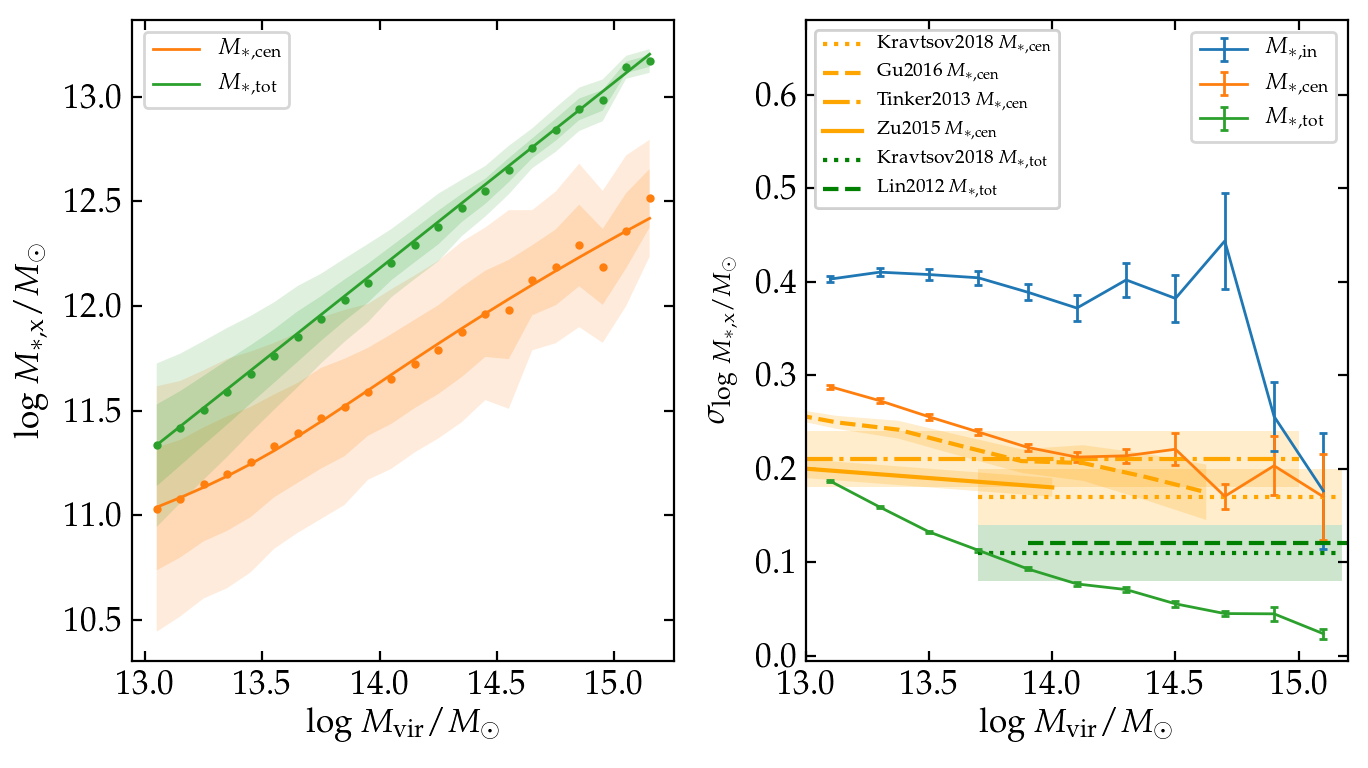

In [13]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
axes[0]._get_lines.get_next_color() # Skip blue to match colors left-right...
p.sm_hm.sm_at_fixed_hm(data_halo_cut["cen"]["data"], "cen", fit=data_halo_cut["cen"]["fit"], ax=axes[0])
p.sm_hm.sm_at_fixed_hm(data_halo_cut["tot"]["data"], "tot", fit=data_halo_cut["tot"]["fit"], ax=axes[0])

p.scatter.in_sm_at_fixed_hm_incl_lit(data_halo_cut, ax=axes[1])
plt.tight_layout()

# Scatter for various definitions of stellar mass

data
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
cen [0.28764802 0.27267933 0.25549007 0.23940126 0.22278579 0.21274007 0.21379347 0.22117198 0.17065538 0.20376055 0.1717185 ]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
1 [0.19871919 0.17761878 0.15938608 0.14846048 0.13810227 0.13495555 0.13190446 0.1267546  0.1091871  0.14716899 0.11099577]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
2 [0.19023755 0.16500939 0.1426999  0.12832868 0.11672258 0.10987905 0.10747831 0.10248664 0.08864798 0.12597716 0.07768755]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
5 [0.18791111 0.16014246 0.1339258  0.11485585 0.09824278 0.08601519 0.08186327 0.07488663 0.06485214 0.09429944 0.047476  ]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
tot [0.1866084  0.15895567 0.13256445 0.11277294 0.09284027 0.07682667 0.07058497 0.05545819 0.04502283 0.04497702 0.02302915]
[11, 27, 62, 149, 353, 839, 1997, 4851, 11385]
cen [0.16392173 0.14098788 0.

(0.0, 0.4610409130488007)

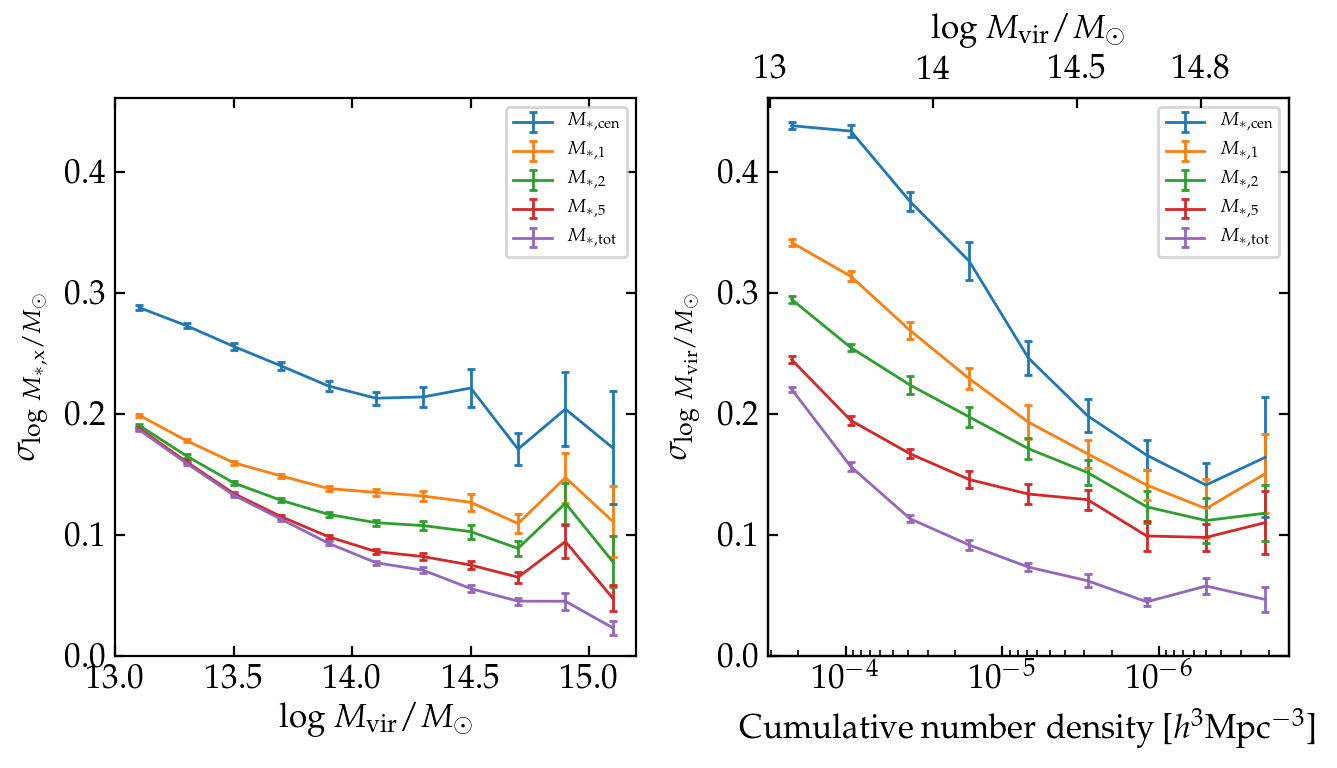

In [14]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.scatter.in_sm_at_fixed_hm(data_halo_cut, ax=axes[0])
p.scatter.in_hm_at_fixed_number_density(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# Physical origin of scatter

In [255]:
# Remember which data you are using!
dhc = data_halo_cut
richn = richness["richness"][["id", "richness"]]
use_cut_data = False

In [256]:
# We define these biases - the difference between the predicted (from the bestfit) and the actual
# We will then try and explain the bias using other halo paramters

cens_bias = halo_info.get_sm_bias(dhc["cen"], include_id=True, use_cut_data=use_cut_data)
cens_bias = pd.DataFrame(cens_bias).set_index("id")
cens_bias = cens_bias.rename(columns={"sm_bias": "cen_sm_bias"})

tot_bias = halo_info.get_sm_bias(dhc["tot"], include_id=True, use_cut_data=use_cut_data)
tot_bias = pd.DataFrame(tot_bias).set_index("id")
tot_bias = tot_bias.rename(columns={"sm_bias": "tot_sm_bias"})

df = data.unify(dhc, "cen", "tot", append=[tot_bias, cens_bias], use_cut_data=use_cut_data)

In [257]:
# We also want to add the accretion rate info as that should be predictive
df["gammas1"] = p.same_hm_dist_plots.f_acc(df, n_dyn=1) # This takes Acc_Rate_1*Tdyn and returns the unitless gamma
df["gammas2"] = p.same_hm_dist_plots.f_acc(df, n_dyn=2)
df["gammas3"] = p.same_hm_dist_plots.f_acc(df, n_dyn="100Myr")

# And concentration
df["concentration"] = df["rvir"] / df["rs"]

# And richness
before_len = len(df)
#df = df.join(pd.DataFrame(richness["richness"][["id", "richness"]]).set_index("id"), how="inner")
df = df.join(pd.DataFrame(richn).set_index("id"), how="inner")
assert len(df) == before_len

468 here are less than 0
7274 here are less than 0


In [258]:
# We will define a third observable of interest - deviance of M*cen at M*tot
res = halo_info.build_sm_sm_bias_fit(df)
df = df.assign(cen_halo_sm_bias = halo_info.get_sm_sm_bias(df, res["fit"]))

['5.20e+11', '2.23e+11', '9.13e-01', '9.22e-03', '1.14e+00']


In [273]:
# We are only interested in the high mass regime
mc = 10**13.5
df_mc = df[df["m"] > mc]

# Remove things with invalid gamma (cbx check what makes this gamma in valid and explain why we can make this cut)
df_mc_valid = df_mc[
    np.logical_not(np.isnan(df_mc["gammas1"])) & np.logical_not(np.isnan(df_mc["gammas2"]))
]
df_valid = df[
     np.logical_not(np.isnan(df["gammas1"])) & np.logical_not(np.isnan(df["gammas2"]))
]

In [274]:
galaxy_properties = ["tot_sm_bias", "cen_sm_bias", "cen_halo_sm_bias", "sm_cen", "icl_cen", "sfr_cen", "sm_tot", "icl_tot", "sfr_tot"]

## Try explain the scatter in M\*cen at fixed M\*tot

Initial scatter: 0.211

concentration    : 0.413
scale_of_last_MM : -0.336
rs               : -0.299
richness         : -0.258
gammas2          : -0.406
Halfmass_Scale   : -0.470
(8988, 30)

Model corrected scatter: 0.166



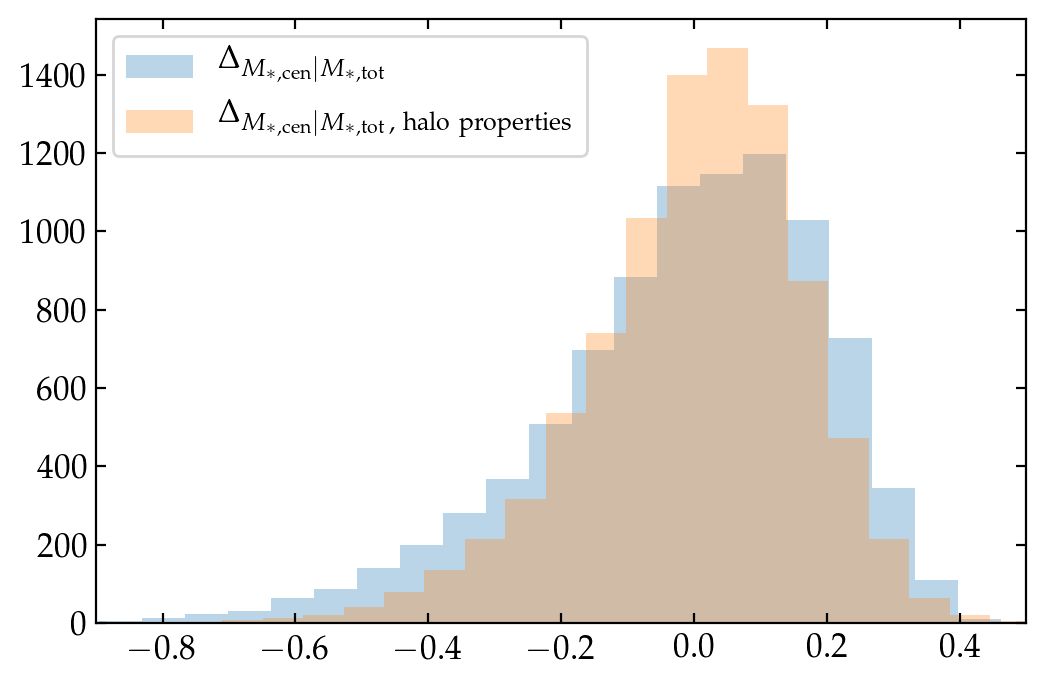

In [277]:
y = df_mc_valid["cen_halo_sm_bias"] # We are trying to explain this bias

print("Initial scatter: {:.3f}\n".format(np.std(y)))

available_x = list(set(df_mc_valid) - set(galaxy_properties))

for col in available_x:
    rho, _ = scipy.stats.spearmanr(y, df_mc_valid[col])
    if np.abs(rho) > 0.25: print("{:<17}: {:.3f}".format(col, rho))

# Build a linear model
x = df_mc_valid[available_x]
"""
print(x.shape)
for col in list(x):
    for poly in range(2, 10):
        n_col = col + str(poly)
        x[n_col] = x[col]**poly
        
print(x.shape)
"""

coef, intercept = p.physical_correlation_plots.linear_fit(x, y, "least_squares")

model = np.dot(x, coef) + intercept

# Plot the comparison
_, ax = plt.subplots()
ax.hist(y, bins=30, label=p.labels.sm_delta_x_given_sm_y("cen", "tot"), alpha=0.3)
#ax.hist(model, bins=30, label="Model", alpha=0.3)
ax.hist(y - model, bins=30, label=p.labels.sm_delta_x_given_sm_y_halo_props("cen", "tot"), alpha=0.3);
ax.legend()
ax.set(xlim=(-0.9, 0.5))
print("\nModel corrected scatter: {:.3f}\n".format(np.std(y - model)))

## Try explain the scatter in M\*tot at fixed Mhalo

Initial scatter: 0.107

concentration    : -0.090
scale_of_last_MM : 0.094
rs               : 0.066
richness         : 0.306
Vmax@Mpeak       : -0.050
(8988, 30)

Model corrected scatter: 0.097



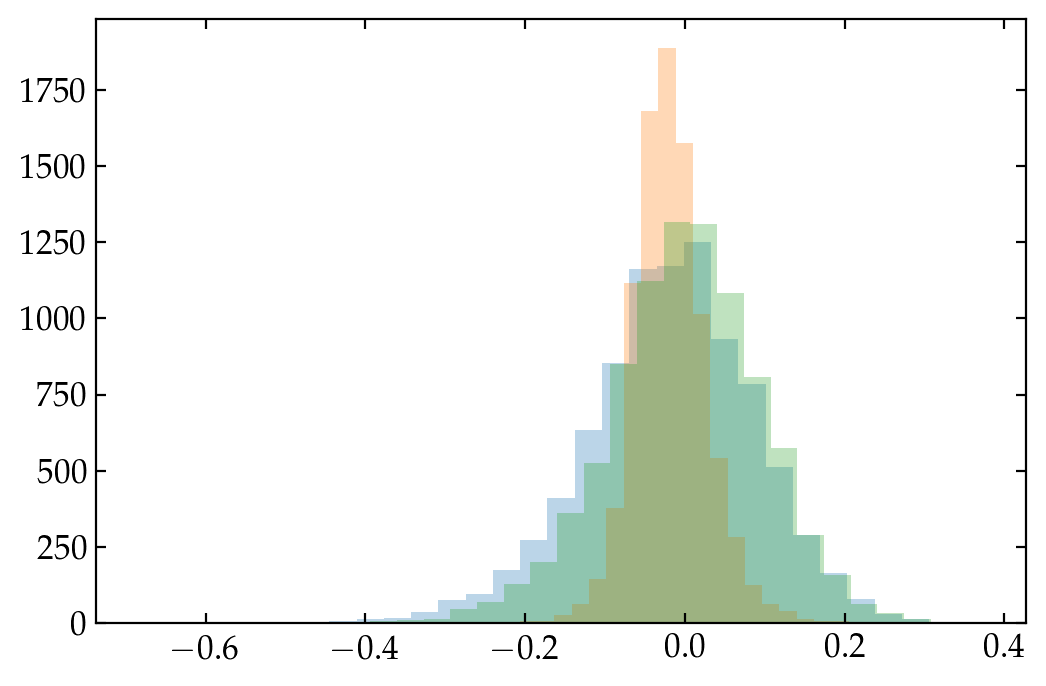

In [275]:
y = df_mc_valid["tot_sm_bias"] # We are trying to explain this bias
print("Initial scatter: {:.3f}\n".format(np.std(y)))

available_x = list(set(df_mc_valid) - set(galaxy_properties))

for col in available_x:
    rho, _ = scipy.stats.spearmanr(y, df_mc_valid[col])
    if np.abs(rho) > 0.05: print("{:<17}: {:.3f}".format(col, rho))

# Build a linear model
x = df_mc_valid[available_x]

"""
# Test fitting polynomials.
# This doesn't help much
print(x.shape)
for col in list(x):
    for poly in range(2, 10):
        n_col = col + str(poly)
        x[n_col] = x[col]**poly
        
print(x.shape)
"""

coef, intercept = p.physical_correlation_plots.linear_fit(x, y, "least_squares")

model = np.dot(x, coef) + intercept

# Plot the comparison
_, ax = plt.subplots()
ax.hist(y, bins=30, label="UM", alpha=0.3)
ax.hist(model, bins=30, label="Model", alpha=0.3)
ax.hist(y - model, bins=30, label="Model", alpha=0.3);

print("\nModel corrected scatter: {:.3f}\n".format(np.std(y - model)))

## Resampling to estimate stochastic scatter

In [278]:
cuts = (10**13.6, 10**13.63)
cut_sample_halo = data_halo_cut["tot"]["data"][
    (data_halo_cut["tot"]["data"]["m"] > cuts[0]) & (data_halo_cut["tot"]["data"]["m"] < cuts[1])
]
cut_sample_cen = data_halo_cut["cen"]["data"][
    (data_halo_cut["cen"]["data"]["m"] > cuts[0]) & (data_halo_cut["cen"]["data"]["m"] < cuts[1])
]
assert np.all(cut_sample_cen["id"] == cut_sample_halo["id"])
ids = cut_sample_halo["id"]
print(len(ids))

uncut_sat_sample = satellites[np.isin(satellites["upid"], ids)]
uncut_num_sats = np.array([np.count_nonzero(uncut_sat_sample["upid"] == idx) for idx in ids])

610


0.15877981718478365 0.12115812488993379


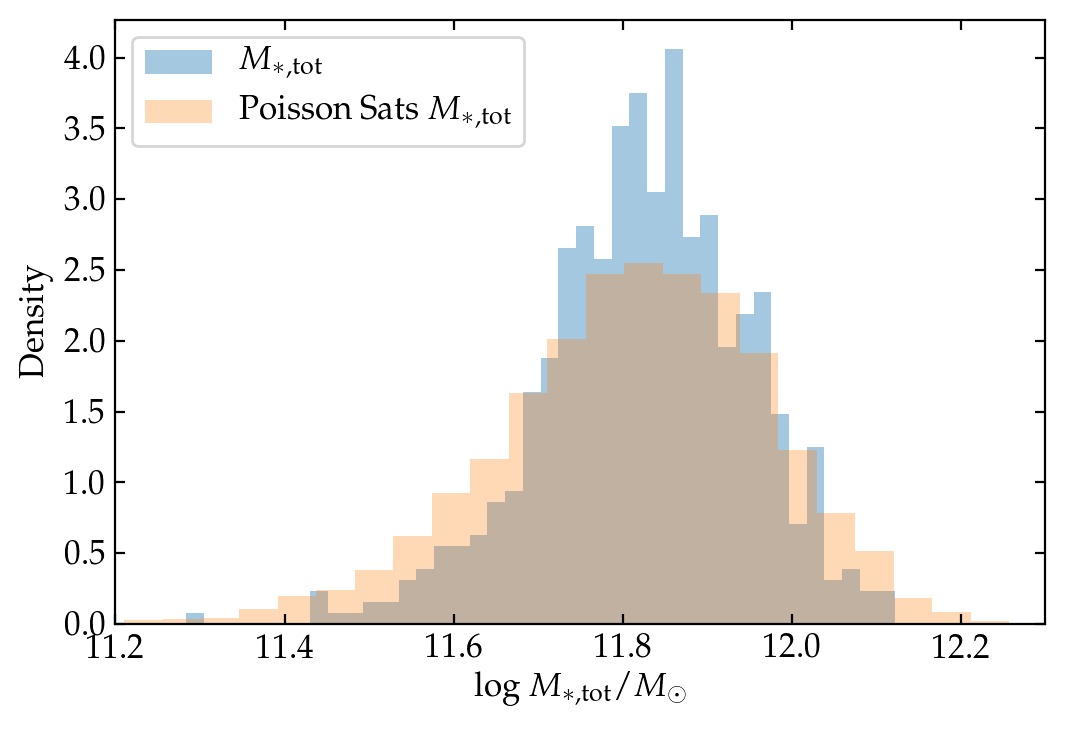

In [282]:
# Scatter in the current data set
_, ax = plt.subplots()
mass = np.log10(cut_sample_halo["sm"] + cut_sample_halo["icl"])
_, bins, _ = ax.hist(mass, bins=40, alpha=0.4, label=p.labels.m_star_legend("tot"), density=True)

# Scatter in the resampled data set
full_poisson_masses, half_poisson_masses, fpmnc = origin_scatter.resample.resample_sats(cut_sample_cen, uncut_sat_sample, uncut_num_sats)

ax.hist(full_poisson_masses, bins=30, alpha=0.3, label="Poisson Sats " + p.labels.m_star_legend("tot"), density=True)
#ax.hist(half_poisson_masses, bins=30, alpha=0.3, label="Half Poisson scatter", density=True)
ax.set(
    xlabel=p.labels.m_star_x_axis("tot"),
    ylabel="Density",
    xlim=(11.2, 12.3),
)
#ax.annotate(xy=(0.04, 0.5), s="13.6 < Mvir < 13.63", xycoords="axes fraction")
ax.legend()
print(np.std(full_poisson_masses), np.std(mass))

## Explain why we see large spearman rank correlation coefficients without a large degree of explanatory power

SRCC: -0.26
PRCC: -0.13

Coef: -0.01
Intercept: 0.02

Scatter (uncorrected - top plot): 0.211
Scatter (corrected - bot plot): 0.209


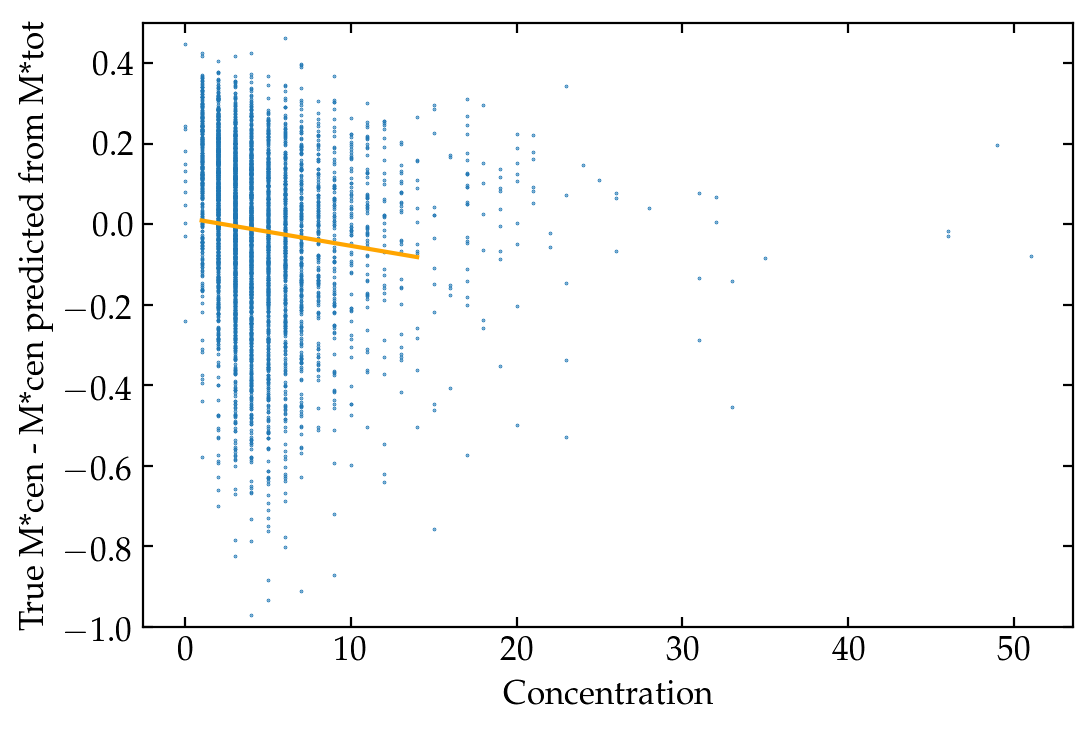

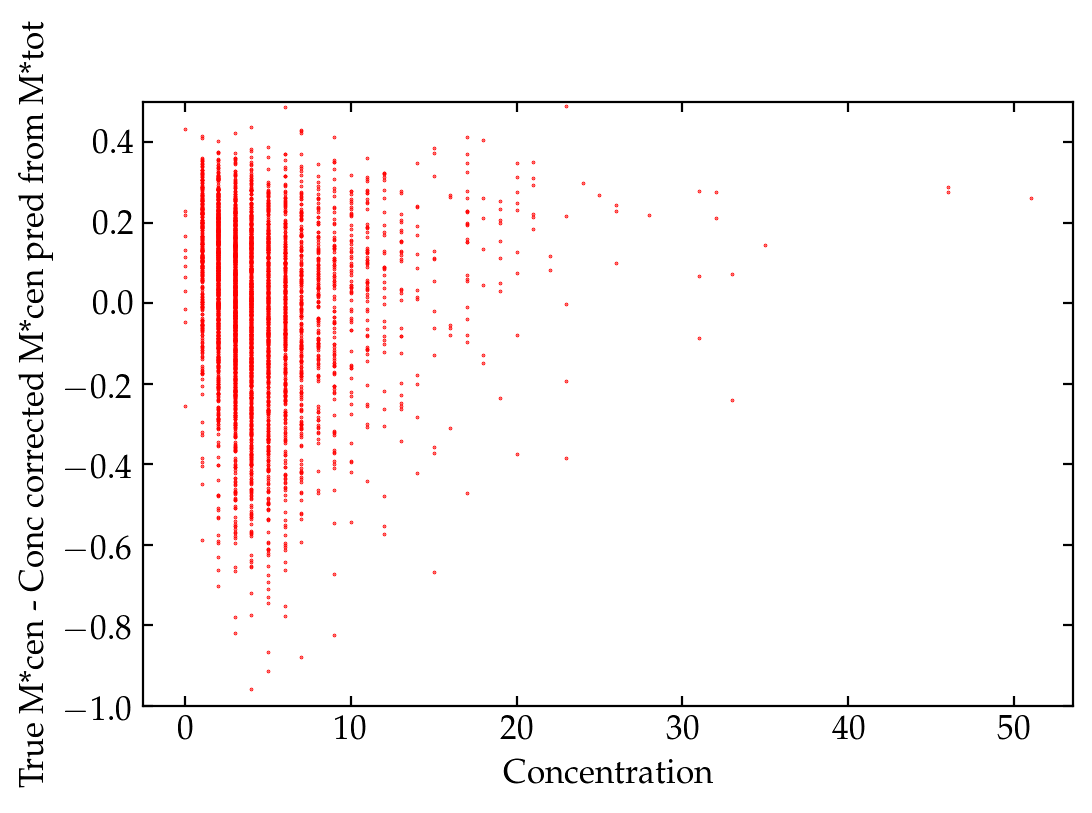

In [250]:
# This is confusing. For e.g. M*cen at fixed M*tot we see that concentration is 0.4 correlated with the scatter. But then surely if should explain more than the 0.05 dex of scatter?
y = df_mc_valid["cen_halo_sm_bias"]
x = df_mc_valid["richness"]

ds = 2 # downsample
_, ax = plt.subplots()

ax.scatter(x[::ds], y[::ds], s=0.1)
print("SRCC: {:.2f}".format(scipy.stats.spearmanr(y, x).correlation))
print("PRCC: {:.2f}".format(scipy.stats.pearsonr(y, x)[0]))

clf = sklearn.linear_model.LinearRegression(normalize=True)
fit = clf.fit(x.values.reshape(-1, 1), y)

print()
print("Coef: {:.2f}\nIntercept: {:.2f}".format(fit.coef_[0], fit.intercept_))

fit_x = np.linspace(1, 14)
ax.plot(fit_x, fit.intercept_ + fit.coef_[0] * fit_x, color="orange")

ax.set(
    xlabel="Concentration",
    ylabel="True M*cen - M*cen predicted from M*tot",
    ylim=(-1, 0.5)
)

corrected_y = y - (fit.intercept_ + fit.coef_[0] * x)

_, ax = plt.subplots()
ax.scatter(x[::ds], corrected_y[::ds], s=0.1, color="red")
ax.set(
    xlabel="Concentration",
    ylabel="True M*cen - Conc corrected M*cen pred from M*tot",
    ylim=(-1, 0.5),
)

print()
print("Scatter (uncorrected - top plot): {:.3f}\nScatter (corrected - bot plot): {:.3f}".format(np.std(y), np.std(corrected_y)))

## Sanity checks

In [79]:
# All biases should average to 0 (else our fit is bad)
print(len(df))
for bias in ["cen_halo_sm_bias", "tot_sm_bias", "cen_sm_bias"]:
    print(np.mean(df[bias]))

1076948
0.00013518044545439203
-0.062496541533895285
0.0007683297849828373


In [80]:
print(np.corrcoef(df_mc["cen_halo_sm_bias"], df_mc["tot_sm_bias"]))

[[1.         0.01163672]
 [0.01163672 1.        ]]


In [78]:
# In the high mass section the covariance between M*tot - Mhalo and M*cen - M*tot should be low
# else our dividing of the scatter into these components is not valid
print(np.corrcoef(df_mc["cen_halo_sm_bias"], df_mc["tot_sm_bias"]))

[[1.         0.01163672]
 [0.01163672 1.        ]]


# Gamma

In [185]:
# We need to combine the data with the SM cuts. Basically it is the same as we did about with the data_halo_cut
# but now it is with the data_stellar_cut.

dsc = data_stellar_cut_specz
use_cut_data = True

# Make sure the df is using the same type of data (specz/photoz/true) as here!

scdf = data.unify_different(dsc, "cen", "tot", use_cut_data=use_cut_data)
scdf = scdf.rename(columns = {
    "m_cen": "m",
    "Acc_Rate_1*Tdyn_cen": "Acc_Rate_1*Tdyn",
    "Acc_Rate_2*Tdyn_cen": "Acc_Rate_2*Tdyn",

}) # Need to do this for the f_acc func to find the cols
scdf["gammas2"] = p.same_hm_dist_plots.f_acc(scdf, n_dyn=2)
scdf["gammas1"] = p.same_hm_dist_plots.f_acc(scdf, n_dyn=1)

scdf_valid = scdf[
     np.logical_not(np.isnan(scdf["gammas1"])) & np.logical_not(np.isnan(scdf["gammas2"]))
]

37505 25489
19371
278 here are less than 0
19 here are less than 0


In [89]:
gamma = "gammas2"

Invalidating < 15
Invalidating < 15
Invalidating < 15
Invalidating < 15
1.034973574535329
Invalidating < 12
Invalidating < 12


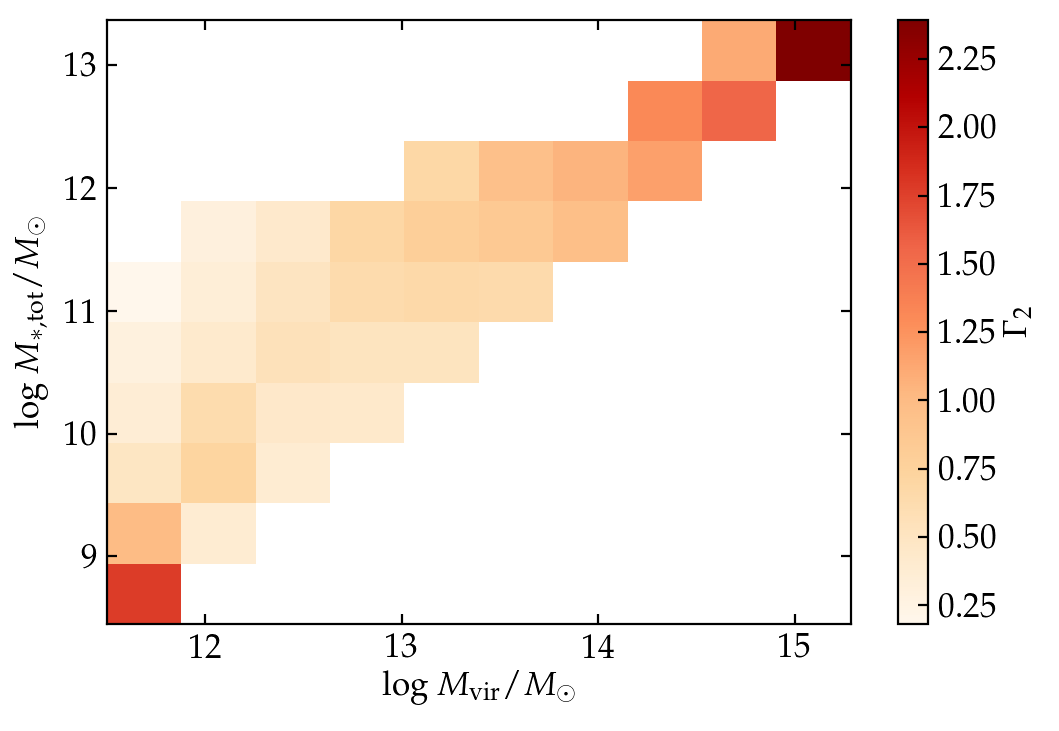

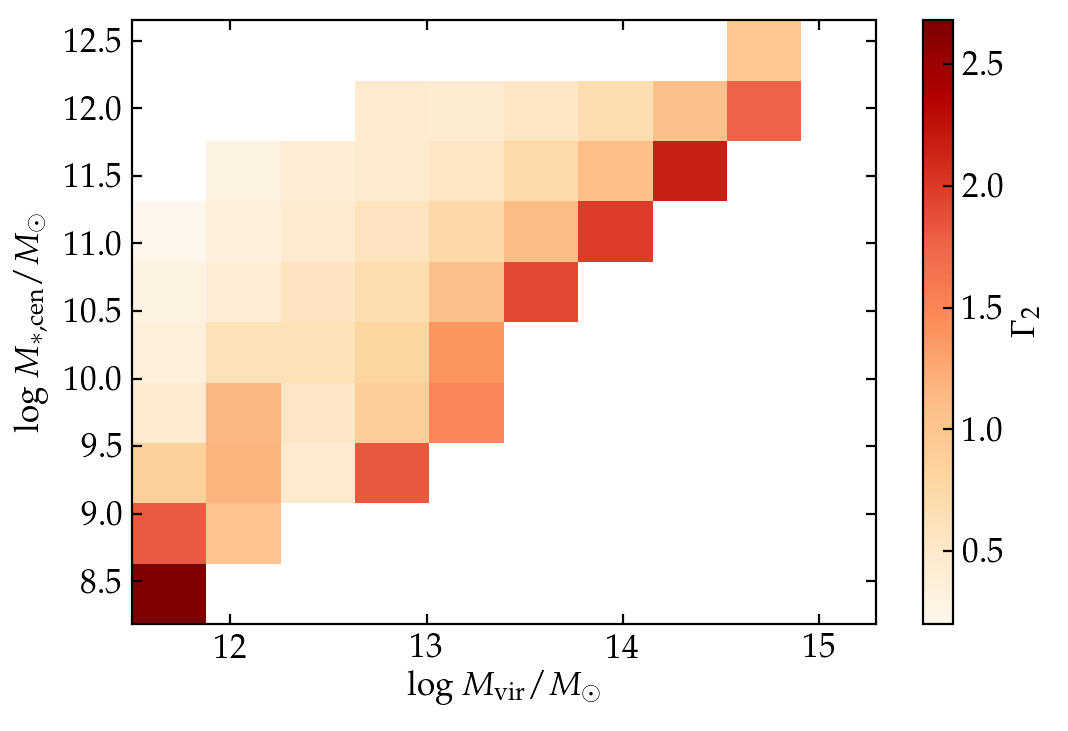

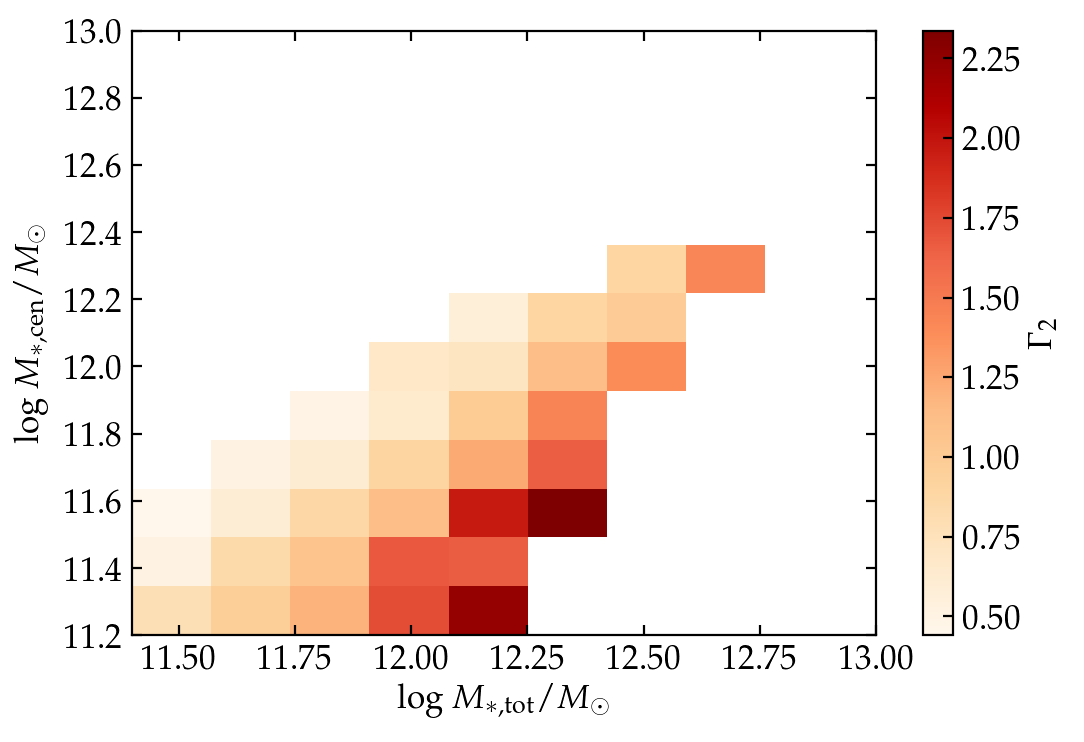

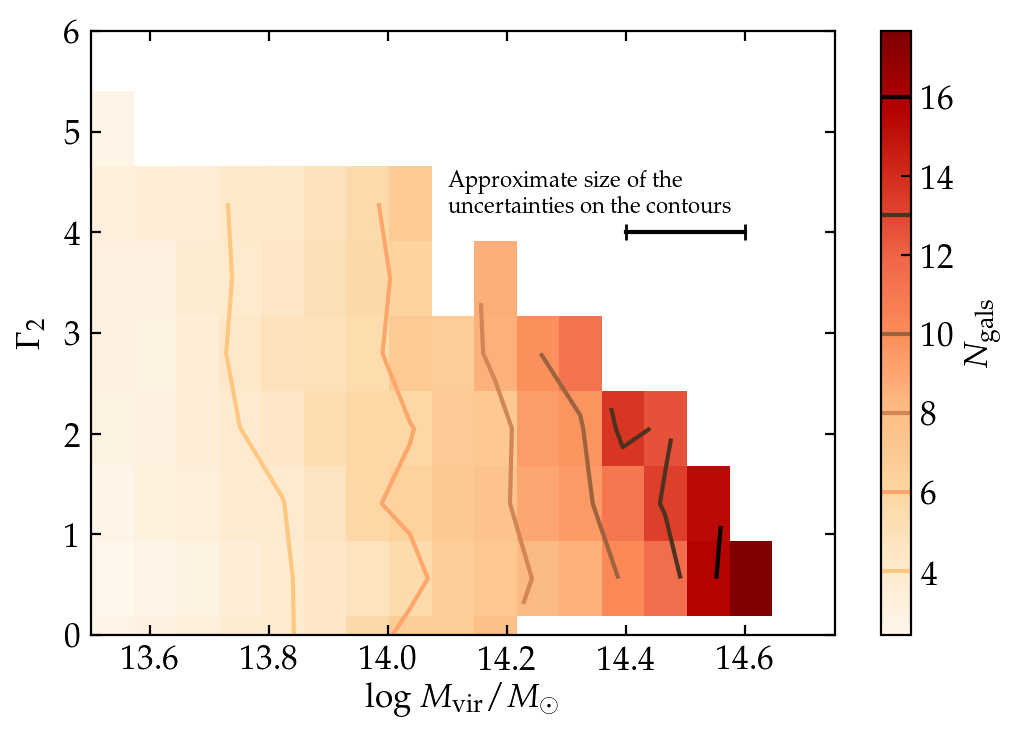

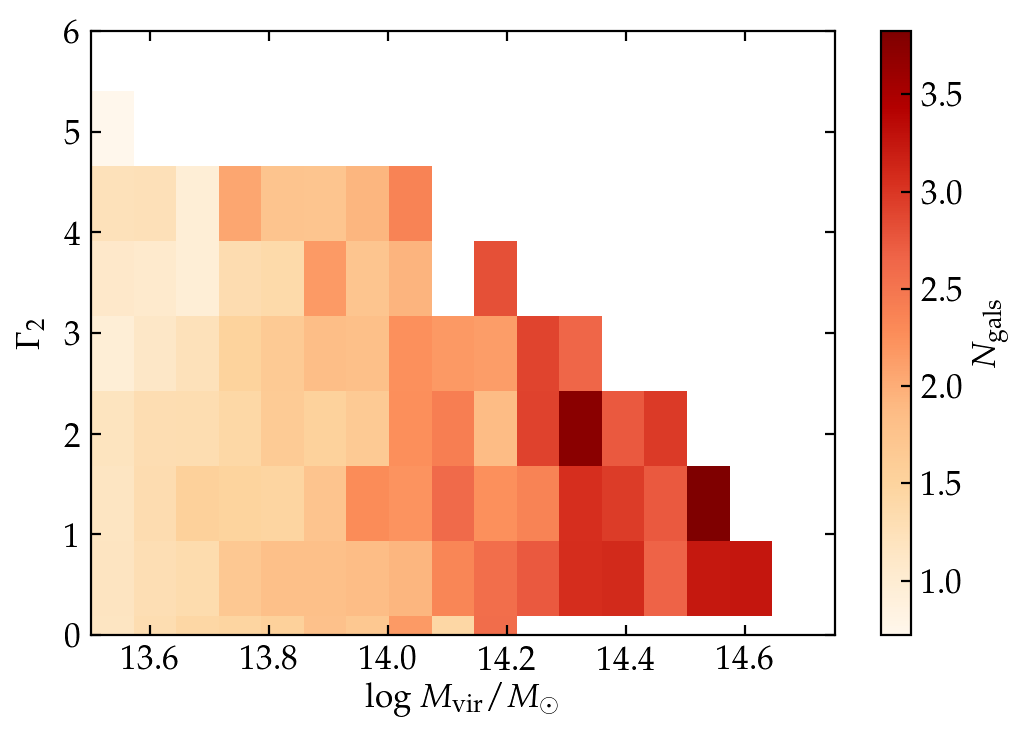

In [298]:
# M*tot at fixed Mvir isn't dependent on accretion
p.gamma.gamma_in_mvir_mstarx_bins(
    df_valid["mp"],
    df_valid["sm_tot"] + df_valid["icl_tot"],
    df_valid[gamma],
    "tot",
)

# M*cen at fixed Mvir is dependent on accretion.
# Large M*cen means less recent accretion
p.gamma.gamma_in_mvir_mstarx_bins(
    df_valid["mp"],
    df_valid["sm_cen"] + df_valid["icl_cen"],
    df_valid[gamma],
    "cen",
)

# M*cen at fixed M*tot is dependent on accretion
# Larce M*cen means less recent accretion
# This follows pretty directly from the first two
p.gamma.gamma_in_mstarcen_mstartot_bins(
    scdf_valid["sm_cen"] + scdf_valid["icl_cen"],
    scdf_valid["sm_tot"] + scdf_valid["icl_tot"],
    scdf_valid[gamma],
)

# At this point we have a theory that the reason M*cen is large with less recent accretion
# is because satellites have had time to merge on the central. We can test that theory by
# checking the number of satellites. If this theory is true we expect to see more satellites
# in high gamma systems. And we see that . . . 

# The number of satellites is not that sensitive to gamma!
p.gamma.mhalo_gamma_richness(df_mc_valid)

# So what could explain all of these things?

# It looks like from https://arxiv.org/pdf/0707.2960.pdf that larger satellites merge quicker
# So lets say that only the very largest satellites merge which bumps up M*cen at fixed M*tot for low accretion
# But the merger timescales of most of the galaxies that our richness estimator measures have decay timescales
# that are longer.

0.0 0.28730717043745707
528
380


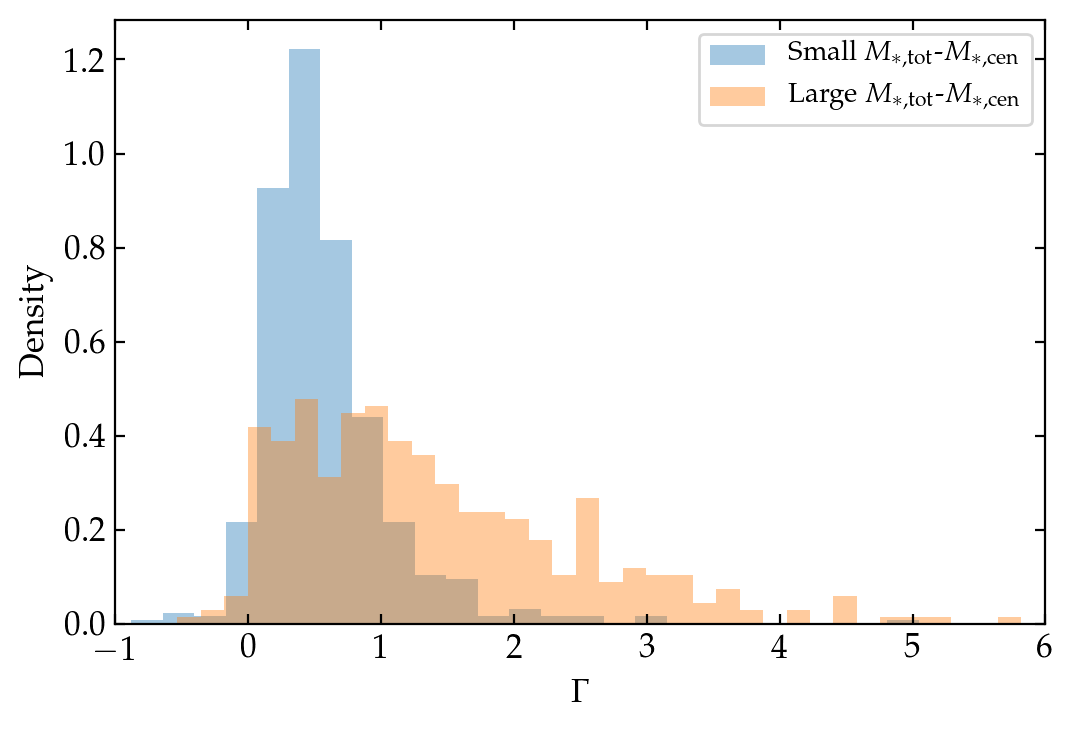

In [333]:
# Ok so we have these trends on average but what can we say for individual galaxies
p.gamma.gamma_of_fixed_cen_and_split_tot_pops(
    scdf_valid["sm_cen"] + scdf_valid["icl_cen"],
    scdf_valid["sm_tot"] + scdf_valid["icl_tot"],
    scdf_valid[gamma],
)

# Stuff that is not final but that has made its way here because this is now clean so lets make it dirty

In [105]:
# PLOT 1 : using the UM, plot M*galaxy versus Vpeak. For centrals, I think we want all of the mass so BCG+ICL. Plot centrals and satellites on a separate figure. Color code centrals according to halo age.
# PLOT 2: at fixed halo mass, there is a distribution of M*tot values. Compute the mean M*tot value. Rescale all of the mass in a given halo by M*tot/M*tot mean. Plot the same figure above. Is the scatter changed?